# Bag-of-words classifier with pretrained word embeddings

- If we have a trained word embeddings model, we can transfer that knowledge into a new task and model
- Initialize the weights in the classifier with pretrained word embeddings
- Word embeddings downloaded at https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip

### Read data

In [1]:
import json
import random
with open("data/imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) 
print(data[0])

# We need to gather the texts, into a list
texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]
print(texts[:2])
print(labels[:2])

{'class': 'pos', 'text': 'The stories in this video are very entertaining, and it definately is worth a look! The first one concerns a young couple harrassed in the woods by two rednecks, with a great, but unexplained twist at the end.  The seond is the best of the lot, and it alone, makes this worth watching - A man is attacked by a dog, which he fears to be rabid - He finds shelter in what appears to be a hospital, but he finds out the employees there are not exactly what they appear to be...... Great twist at the end, and this episode alone scores 10/10! If the others were up to par with this one, this would get 10/10!  The third is the weakest of the bunch - A girl meets with some guys and has wild sex! There appears to be no point to the story until the end, with a good little twist, but it is spoiled by the awful first part!  Never the less, this is a great movie that will not do you wrong at all! Well worth a rental!'}
['The stories in this video are very entertaining, and it de

### Use gensim to read the embedding model

In [2]:
from gensim.models import KeyedVectors

vector_model=KeyedVectors.load_word2vec_format("data/wiki-news-300d-1M.vec", binary=False, limit=50000)

# sort based on the index to make sure they are in the correct order
words=[k for k,v in sorted(vector_model.vocab.items(), key=lambda x:x[1].index)]
print("Words from embedding model:",len(words))
print("First 50 words:",words[:50])

Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']


### Normalize the vectors

- Easier to learn on top of these vectors when the magnitude does not vary much

In [3]:
print("Before normalization:",vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:",vector_model.get_vector("in")[:10])

Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


### Text analyzer and vectorizer

- When we use an embedding layer (keras.layers.Embedding) the input data must be a sequence, not a bag-of-words vector
- You can use CountVectorizer only as an analyzer without building the feature matrix
- We will then build the vectorizer part later ourselves

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy
analyzer=CountVectorizer(lowercase=False).build_analyzer() # includes tokenizer and preprocessing
print(analyzer(texts[0]))



['The', 'stories', 'in', 'this', 'video', 'are', 'very', 'entertaining', 'and', 'it', 'definately', 'is', 'worth', 'look', 'The', 'first', 'one', 'concerns', 'young', 'couple', 'harrassed', 'in', 'the', 'woods', 'by', 'two', 'rednecks', 'with', 'great', 'but', 'unexplained', 'twist', 'at', 'the', 'end', 'The', 'seond', 'is', 'the', 'best', 'of', 'the', 'lot', 'and', 'it', 'alone', 'makes', 'this', 'worth', 'watching', 'man', 'is', 'attacked', 'by', 'dog', 'which', 'he', 'fears', 'to', 'be', 'rabid', 'He', 'finds', 'shelter', 'in', 'what', 'appears', 'to', 'be', 'hospital', 'but', 'he', 'finds', 'out', 'the', 'employees', 'there', 'are', 'not', 'exactly', 'what', 'they', 'appear', 'to', 'be', 'Great', 'twist', 'at', 'the', 'end', 'and', 'this', 'episode', 'alone', 'scores', '10', '10', 'If', 'the', 'others', 'were', 'up', 'to', 'par', 'with', 'this', 'one', 'this', 'would', 'get', '10', '10', 'The', 'third', 'is', 'the', 'weakest', 'of', 'the', 'bunch', 'girl', 'meets', 'with', 'some', 

### Expand the vocabulary using words from the embedding model

- The embedding model usually knows more words than the task specific model, because it has seen a lot more data
- If you wish, you can use the embedding model vocabulary to expand the task specific one

In [20]:
# init the vectorizer vocabulary using words from the embedding model
def init_vocabulary(vocab, text, text_analyzer):
    for word in analyzer(text):
        # Only use pretrained vocabulary
        if word in vector_model.vocab:
            vocab.setdefault(word, len(vocab))
    return vocab

words_from_model=" ".join(words[:50000]) # use 50K words from the embedding model to initialize the vocabulary --> expands the learned vocabulary
vocabulary={"<SPECIAL>": 0} # zero has a special meaning in sequence models, prevent using it for a normal word
vocabulary=init_vocabulary(vocabulary, words_from_model, analyzer)
print("Words from embedding model:",len(vocabulary))


Words from embedding model: 47852


### Vectorizer

- Build a dictionary to turn words into numbers, here we use the one which we initialized with the embedding model
- Vectorizing a sequence: In our data each example is a list of words, we need to turn each example into list of numbers

In [21]:
def vectorizer(vocab, texts):
    vectorized_data=[] # turn text into numbers based on our vocabulary mapping
    for one_example in texts:
        vectorized_example=[]
        for word in analyzer(one_example):
            # Only use pretrained vocabulary
            if word in vector_model.vocab:
                vectorized_example.append(vocab[word])
            #vocab.setdefault(word, len(vocab)) # add word to our vocabulary if it does not exist
            #vectorized_example.append(vocab[word])
        vectorized_data.append(vectorized_example)
    
    vectorized_data=numpy.array(vectorized_data) # turn python list into numpy matrix
    return vectorized_data, vocab

vectorized_data, vocabulary=vectorizer(vocabulary, texts)

# now vectorized data is the same as feature_matrix, but in different format
print("Words in vocabulary:",len(vocabulary))
print("Vectorized data shape:",vectorized_data.shape)
print("First example vectorized:",vectorized_data[0])
inversed_vocabulary={value:key for key, value in vocabulary.items()} # inverse the dictionary
print("First example text:",[inversed_vocabulary[idx] for idx in vectorized_data[0]])
        

Words in vocabulary: 47852
Vectorized data shape: (25000,)
First example vectorized: [13, 1421, 5, 19, 685, 21, 183, 8288, 2, 12, 26983, 7, 1534, 308, 13, 90, 29, 1060, 745, 1965, 5, 1, 11588, 16, 85, 10, 353, 32, 17120, 8474, 18, 1, 406, 13, 7, 1, 256, 3, 1, 1461, 2, 12, 868, 571, 19, 1534, 2175, 305, 7, 2912, 16, 2286, 25, 37, 4629, 4, 24, 23772, 140, 3078, 5355, 5, 58, 937, 4, 24, 999, 32, 37, 3078, 75, 1, 1018, 62, 21, 22, 1250, 58, 54, 712, 4, 24, 1540, 8474, 18, 1, 406, 2, 19, 1374, 868, 3283, 118, 118, 93, 1, 208, 42, 71, 4, 6666, 10, 19, 29, 19, 63, 129, 118, 118, 13, 660, 7, 1, 29056, 3, 1, 9396, 1759, 2545, 10, 48, 2713, 2, 28, 3229, 1746, 374, 937, 4, 24, 82, 158, 4, 1, 372, 222, 1, 406, 10, 142, 411, 8474, 32, 12, 7, 16966, 16, 1, 6506, 90, 237, 5969, 1, 395, 19, 7, 353, 1056, 6, 39, 22, 79, 20, 521, 18, 26, 1707, 1534, 10187]
First example text: ['The', 'stories', 'in', 'this', 'video', 'are', 'very', 'entertaining', 'and', 'it', 'definately', 'is', 'worth', 'look', 'The',

### Labels into onehot vectors

- Same as in the original BOW classifier

In [22]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
one_hot_encoder=OneHotEncoder(sparse=False) #Turns class integers into one-hot encoding
class_numbers=label_encoder.fit_transform(labels)
print("class_numbers shape=",class_numbers.shape)
print("class_numbers",class_numbers)
print("class labels",label_encoder.classes_)
#And now yet the one-hot encoding
classes_1hot=one_hot_encoder.fit_transform(class_numbers.reshape(-1,1))
print("classes_1hot",classes_1hot)


class_numbers shape= (25000,)
class_numbers [1 0 0 ... 1 1 0]
class labels ['neg' 'pos']
classes_1hot [[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


## Network

- First we need to create an embedding matrix which we can then plug into the neural network
- The embedding matrix must follow the order from the vectorizer

In [23]:
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings=numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab),embedding_model.vectors.shape[1])) # initialize new matrix (words x embedding dim)
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)
print("Shape of pretrained embeddings:",pretrained.shape)
print("Vector for the word 'in':",pretrained[vocabulary["in"]][:10])


Found pretrained vectors for 47851 words.
Shape of pretrained embeddings: (47852, 300)
Vector for the word 'in': [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


### Sequential input

- Remember how the shape of the input data matrix had undefined number of columns
- Now we must make it into fixed size (same for each example)
- Padding: include zeros until you reach the correct size
- You will hear more about this next week!

In [25]:
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post')
print("New shape:", vectorized_data_padded.shape)
print("First example:", vectorized_data_padded[0])

Old shape: (25000,)
New shape: (25000, 2226)
First example: [  13 1421    5 ...    0    0    0]


A simple network with a single convolutional layer with window size of 2 words (bigrams), 50 kernels and global max pooling (only the maximum value from each kernel is preserved). We create a separate model with the CNN layer as the output. This model shares weights with the actual model and can be used in analysing the kernel activations in each time step.

In [44]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, Conv1D, GlobalMaxPooling1D
from keras import backend as K
from keras.layers.core import Lambda
from keras.optimizers import SGD, Adam


example_count,sequence_len=vectorized_data_padded.shape
example_count,class_count=classes_1hot.shape

vector_size=pretrained.shape[1] # embedding dim ("hidden layer") must be the same as in the pretrained model
kernels = 50
window_size = 2 # How many words a kernel sees at a time

inp=Input(shape=(sequence_len,))
embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, weights=[pretrained], trainable=False)(inp)
cnn = Conv1D(kernels,window_size,padding='valid',activation='relu',strides=1)(embeddings)
pooling = GlobalMaxPooling1D()(cnn)
outp=Dense(class_count, activation="softmax")(pooling)
model=Model(inputs=[inp], outputs=[outp])

optimizer=Adam(lr=0.001) # define the learning rate
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=['accuracy'])

# This is our model for outputting the time step wise kernel activations.
cnn_out_model=Model(inputs=[inp], outputs=[cnn])
# We have to compile the model, but we nerver train it directly
cnn_out_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

print(model.summary())

# train
hist=model.fit(vectorized_data_padded,classes_1hot,batch_size=100,verbose=1,epochs=10,validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2226)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 2226, 300)         14355600  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2225, 50)          30050     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 14,385,752
Trainable params: 30,152
Non-trainable params: 14,355,600
_________________________________________________________________
None
Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 7s 299us/step

Things to note:
1. We are using ReLU activation as it simplifies our life
2. The word embeddings are now fixed, i.e. the training algorithm is not allowed to change the pretrained embeddings

History: [0.8323999953269958, 0.857999997138977, 0.867999997138977, 0.8723999953269959, 0.8811999988555909, 0.8872000026702881, 0.8872000002861022, 0.8912000012397766, 0.8935999989509582, 0.8928000020980835]
Max accuracy: 0.8935999989509582


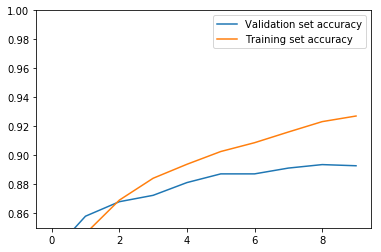

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
print("History:",hist.history["val_acc"])
print("Max accuracy:",numpy.max(hist.history["val_acc"]))
plt.ylim(0.85,1.0)
plt.plot(hist.history["val_acc"],label="Validation set accuracy")
plt.plot(hist.history["acc"],label="Training set accuracy")
plt.legend()
plt.show()

Lets make predictions for the whole training and validation data to see what type of bigrams each kernel has learnt to recognize.

In [50]:
input_data = hist.validation_data[0] # Use vectorized_data_padded if you want activations for the training data as well
predictions = cnn_out_model.predict(input_data, verbose=1, batch_size=64)
print("Predictions shape:", predictions.shape)

2500/2500 [==============================] - 4s 2ms/step
Predictions shape: (2500, 2225, 50)


In [53]:
word_embeddings = model.layers[1].get_weights()[0]
print("Word embeddings from the model:", word_embeddings.shape)
print("Kernels:", model.layers[2].get_weights()[0].shape)
for kernel_index in range(model.layers[2].get_weights()[0].shape[-1]):
    kernel = model.layers[2].get_weights()[0][:,:,kernel_index] + model.layers[2].get_weights()[1][kernel_index]

    # Hypothetical highest activations
    activations = numpy.dot(kernel, word_embeddings.T)
    best_word_indices = numpy.argmax(activations, axis=-1)
    
    # Highest activations seen in the validation data
    max_time_steps = numpy.argmax(predictions[:,:,kernel_index], axis=-1)
    max_activations = numpy.max(predictions[:,:,kernel_index], axis=-1)
    best_sentences = numpy.argsort(-max_activations)
    
    best_ngrams = [input_data[best_sentences[nth]][max_time_steps[best_sentences[nth]]:max_time_steps[best_sentences[nth]]+window_size] for nth in range(10)]
    best_ngrams = [' '.join([inversed_vocabulary[i] for i in best]) for best in best_ngrams]
    best_ngrams = ' | '.join(best_ngrams)
 
    print('Kernel %s:' % kernel_index)
    print(best_ngrams)
    print('Hypothetical maximum activation %s:' % kernel_index, ' '.join([inversed_vocabulary[wi] for wi in best_word_indices]), numpy.max(activations, axis=-1), '\n')

Word embeddings from the model: (47852, 300)
Kernels: (2, 300, 50)
Kernel 0:
still manages | still manages | still brings | still unveils | today Jake | still makes | still makes | still makes | today adventure | still finds
Hypothetical maximum activation 0: today uncovers [0.9590905 0.8074217] 

Kernel 1:
zero emotion | no redeeming | no redeeming | no redeeming | no redeeming | no redeeming | no redeeming | no redeeming | no redeeming | no redeeming
Hypothetical maximum activation 1: whatsoever redeeming [1.1030507  0.87583375] 

Kernel 2:
absolutely perfect | absolutely perfect | also perfect | is perfect | is perfect | is perfect | is perfect | is perfect | is perfect | is perfect
Hypothetical maximum activation 2: hereby perfect [0.60775065 1.5542    ] 

Kernel 3:
boring scenes | boring scenes | dull with | boring with | boring with | boring with | boring with | dull characters | dull and | dull and
Hypothetical maximum activation 3: dull Editing [1.0966085 0.4052556] 

Kernel 4:

Kernel 36:
flimsy plot | flimsy plot | weak plot | weak plot | existent plot | lacking storyline | discernible plot | discernible plot | Worst plot | bad plot
Hypothetical maximum activation 36: Useless plot [0.5839009 0.6621209] 

Kernel 37:
flawless acting | superb soundtrack | beautifully crafted | superbly performed | perfectly crafted | flawless performance | superb film | superb film | perfect film | perfect film
Hypothetical maximum activation 37: flawless Produced [1.212911   0.54238904] 

Kernel 38:
Frank Sinatra | Frank Sinatra | Frank Sinatra | Frank Sinatra | unexpected gritty | Clint Eastwood | Clint Eastwood | Clint Eastwood | Clint Eastwood | Clint Eastwood
Hypothetical maximum activation 38: Vicente Sinatra [0.5512372  0.58232844] 

Kernel 39:
just awful | just awful | just awful | just awful | just awful | just horrible | just horrible | just horrible | just horrible | just horrible
Hypothetical maximum activation 39: just awful [0.8347242  0.92426133] 

Kernel 40:
WRO

Lets have a look at some of the kernels, e.g. kernel 10:

Worst script | incoherent script | worst acting | worst acting | worst acting | abysmal screenplay | worst written | poorly scripted | poorly filmed | poorly directed
Hypothetical maximum activation 10: worst script [1.0209291 0.7113825]

* The activating bigram seems to be a negative adjective and a movie related concept
* The hypothetical maximum activation we can generate with the given vocabulary is "worst script", which is very close to the first actual hit, however, this is not always the case:

Kernel 13:
movie sorry | movie Sorry | movie Oh | movie Oh | movie Oh | movie oh | movie oh | movie fails | movie fails | movie fails

Hypothetical maximum activation 13: porn oops [0.6134886 1.025104 ]

Sometimes the kernels are uninterpretable or they make unrealistic assumptions about the the shape of the word embedding space.

* Window size does not force the kernel to learn certain length n-grams (only sets an upper boundary):

Kernel 19:
Great soundtrack | Great film | Great film | great soundtrack | great soundtrack | Great movie | Great Movies | great film | great film | great film

Hypothetical maximum activation 19: Great worksheets [1.0821922 0.6044347]

If we look at the maximum activations for each slot in the above kernel, we notice that the first word has almost twice as high activation as the second one. This means that basically the first word has to be "great" and the second word can be almost anything, i.e. the kernel is only detecting unigrams.

* Looking at the kernel activations does not tell us anything about the kernel importance or relatedness to a certain output (e.g. positive review). To analyze these aspects of the network we have to look into the dense layers following the convolutional layer. This, however, is not straightforward as both CNN kernel activation strengths and dense layer weights should be analyzed together.